In [1]:
using Plots, LaTeXStrings, BenchmarkTools

## The need for differentiation

Computing derivatives is a ubiquitous operation in scientific computing. Examples:
- Optimization
    - Variational inference
    - Parameter fitting (Deep Learning)
- Sensitivity analysis of Differential Equations
- more...

## The alternatives

You have a program computing some quantity (running toy example?). Now you want to also compute the derivative of the output with respect to some parameter. What do you do?
- **Symbolic differentiation** - Requires computation by hand. It's error-prone, and formulas explode in size because of the chain rule. Exact but expensive
- **Finite differences** -> Tradeoff between numerical cancellation and stepsize. Cheap but inaccurate

## Introduction to Automatic Differentiation

Think of a computer program as a (arbitrary complicated) composition of functions
$$f(p) = (f_n \circ f_{n-1} \circ \dots \circ f_2 \circ f_1)(p)$$
which we suppose here to be nice enough (differentiable). Here $p$ is some parameter.

We are interested in computing $f'$. By the chain rule:
$$f'(p) = f_n'(f_{n-1}(\ldots f_1(p)))\cdot f_{n-1}'(f_{n-2}(\ldots f_1(p))) \cdots f_2'(f_1(p))\cdot f_1'(p) $$

Look at this formula and notice that a lot of stuff can be re-used (same idea as dynamic programming!).

Idea: differentiate each step through the program following the chain rule

#### Toy example:
$$f(p) = \log[1-sin^2(4p)]$$

Introduce **dual numbers**, leverage Julia's **type dispatch** system (-> you *almost* don't have to re-write your original code)

In [2]:
struct Dual <: Number
    val::Float64  # value
    der::Float64  # derivative
end

In [3]:
# Sum Rule
Base.:+(f::Dual, g::Dual) = Dual(f.val + g.val, f.der + g.der)

# Product Rule
Base.:*(f::Dual, g::Dual) = Dual(f.val*g.val, f.der*g.val + f.val*g.der)

# Difference Rule
Base.:-(f::Dual, g::Dual) = Dual(f.val - g.val, f.der - g.der)

# Quotient Rule
Base.:/(f::Dual, g::Dual) = Dual(f.val/g.val, (f.der*g.val - f.val*g.der)/(g.val^2))

# Derivative of sin, log
Base.sin(f::Dual) = Dual(sin(f.val), cos(f.val)*f.der)
Base.log(f::Dual) = Dual(log(f.val), 1/f.val*f.der)

# Raise to power by repeatedly squaring
Base.:^(f::Dual, n::Integer) = Base.power_by_squaring(f, n)

Base.convert(::Type{Dual}, x::Real) = Dual(x, zero(x))
Base.promote_rule(::Type{Dual}, ::Type{<:Number}) = Dual

In [4]:
f(p) = log(1-sin(4p)^2)
fprime(p) = -8sin(4p)*cos(4p) / (1 - sin(4p)^2)

fprime (generic function with 1 method)

In [5]:
p = rand()
f(p), fprime(p)

(-0.9916355493170909, -10.417338533259999)

In [6]:
f(Dual(p,1.0))

Dual(-0.9916355493170909, -10.417338533259999)

We are ready to write the code for a generic derivative:

In [7]:
derivative(f::Function, p) = f(Dual(p, 1.0)).der 

derivative (generic function with 1 method)

In [8]:
@show derivative(f, p)
@show fprime(p);

derivative(f, p) = -10.417338533259999
fprime(p) = -10.417338533259999


In practice, differentiation rules are already stored in libraries, no need to write them all ourselves! (see e.g. https://github.com/JuliaDiff/DiffRules.jl/blob/master/src/rules.jl)

## Examples of Forward Mode AD in Julia

### Newton's method without having to manually provide the derivative

Newton's method is a simple solver for non-linear equation, here we consider the single-variable case. 

Given a function in the form $f$, the goal is to compute the value $x^*$ such that $f(x^*)=0$. 
Starting from a random guess $x^{(t=0)}$, the method is iterative and goes as
$$x^{(t+1)} = \frac{f(x^{(t)})}{f'(x^{(t)})} - x^{(t)}.$$

Here we use AD to compute $f'(x^{(t)})$ automatically, without having to provide the function $f'$ explicitly.
The example is for $f(x)=cos(x) - x$, i.e. we look for $x^* : cos(x^*)=x^*$.

In [9]:
function newton(f; x0=rand())
    x = x0
    for it in 1:100
        fprime = derivative(f, x)
        xnew = x - f(x) / fprime
        abs(x - xnew) < 1e-12 && return x
        x, xnew = xnew, x
    end
    x
end

newton (generic function with 1 method)

In [10]:
Base.cos(f::Dual) = Dual(cos(f.val), -sin(f.val)*f.der)

f(x) = cos(x) - x
xstar = newton(f)

0.7390851332151607

In [11]:
cos(xstar), xstar

(0.7390851332151607, 0.7390851332151607)

### Observables of Ising model on random regular lattice

Here we consider the Ising model from statistical mechanics which involves classical "spins" $\{\sigma_i\}_{i=1}^N$ interacting according to the Hamiltonian
$$H(\underline \sigma)=-J\sum_{(ij)}\sigma_i\sigma_j - h\sum_i\sigma_i$$
where $(ij)$ are the edges of a [Random regular lattice](wikipedia.org/) of degree $k$ and size $N\to\infty$. The goal is to compute the average magnetization $m=\frac{1}{N}\sum_{i=1}^N \langle\sigma_i\rangle$, which is done by iterating the following equation (Belief Propagation)
$$u=h + (k-1)\tanh^{-1}[\tanh(u)tanh(J)].$$
On a fixed point $u^*$, the magnetization is obtained as
$$m = \tanh\left[h + (u^*-h)\frac{k}{k-1}\right].$$

We first write a program to compute $m$ at $h=0$, then use automatic differentiation to compute the magnetic susceptibility
$$\chi = \frac{d m}{d h}\left.\right|_{h=0}$$

In [12]:
function magnetiz(J, h, k)
    u = one(h)
    for _ in 1:10^4
        unew = h + (k-1) * atanh(tanh(u)*tanh(J))
        u = unew
    end
    return tanh((h + (u-h)*k/(k-1)))
end

magnetiz (generic function with 1 method)

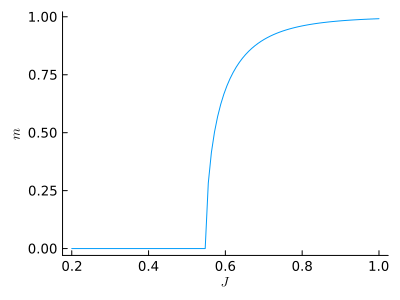

In [18]:
k = 3
h = 0.0
J = LinRange(0.2, 1.0, 100)
m = [magnetiz(JJ, h, k) for JJ in J]

plot(J, m, xlabel=L"J", ylabel=L"m", grid=false, size=(400,300))

In [14]:
Base.tanh(f::Dual) = Dual(tanh(f.val), (1-tanh(f.val)^2) * f.der)
Base.atanh(f::Dual) = Dual(atanh(f.val), inv(1-f.val^2) * f.der)

χ = [derivative(hh -> magnetiz(JJ, hh, k), h) for JJ in J];

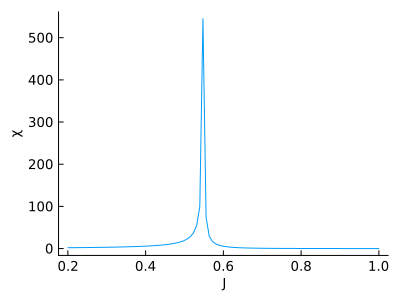

In [19]:
plot(J, χ, xlabel="J", ylabel="χ", grid=false, size=(400,300))

### Benchmark performance

In [16]:
@btime [magnetiz(JJ, h, k) for JJ in $J];

  95.968 ms (203 allocations: 4.06 KiB)


In [17]:
@btime [derivative(hh -> magnetiz(JJ, hh, k), h) for JJ in $J];

  115.418 ms (503 allocations: 11.88 KiB)


# Acknowledgement
The minimal dual number implementation is from https://book.sciml.ai/notes/08-Forward-Mode_Automatic_Differentiation_(AD)_via_High_Dimensional_Algebras/ and https://www.youtube.com/watch?v=vAp6nUMrKYg